In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from env_utils import PDUSession
from nfv_allocation_cpu_env import NfvAllocEnv
from sb3_contrib import MaskablePPO

2024-05-16 17:21:55.608962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 17:21:55.610998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 17:21:55.639100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 17:21:55.639136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 17:21:55.640147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
qi_dict = {3:0.6, 5:0.3, 9:0.1}
env_par={'config_file': 'nuc_host_models.json', 'metric':'power', 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
seed = 10
gamma = 0.05
n_steps = 10_000

env = NfvAllocEnv(**env_par)

f = open('5qi_table.json')
qi_table = json.load(f)

models = [
    "PPO_scale1.5_env8_synth_cpu_seed2_g05_qi359_p631",
    "PPO_scale1.5_env8_synth_power_seed2_g05_qi359_p631",
    "PPO_scale1_env8_synth_cpu_seed2_g05_qi359_p631",
    "PPO_scale1_env8_synth_power_seed2_g05_qi359_p631"
]

models = [
    "PPO_scale1.5_env16_nuc_power_seed2_g05_qi359_p631",
    "PPO_scale1.5_env8_nuc_power_seed2_g05_qi359_p631",
    "PPO_scale1.5_env4_nuc_power_seed2_g05_qi359_p631"
]

[<env_utils.EdgeHost object at 0x71e111dba560>, <env_utils.EdgeHost object at 0x71e111dba590>, <env_utils.EdgeHost object at 0x71e111dba5c0>]


In [3]:
step_data = []
run_data = []

for seed in tqdm([10,11,12,13]):
    
    for model in tqdm(models, leave=True):
    
        path = f'saved models/{model}'
        
        drl_model = MaskablePPO.load(path)
    
        #env.set_gamma(gamma/100)
        obs, info = env.reset(seed=seed)
        
        drl_lat_errors = []
        drl_rewards = []
        
        for step in tqdm(range(n_steps), leave=True):
            mask = env.action_masks()
            action, _states = drl_model.predict(obs, action_masks=mask)
            obs, reward, _, _, info = env.step(action)
            drl_lat_errors.append(info['latency_error'])
            drl_rewards.append(reward)
            step_data.append([seed, model, step, info['power_per_mbit']])
        
        run_data.append([seed, model, np.mean(drl_rewards), np.count_nonzero(drl_lat_errors)/n_steps*100] )
        
step_df = pd.DataFrame(step_data, columns=['seed', 'model', 'step','power'])
run_df = pd.DataFrame(run_data, columns=['seed', 'model', 'reward', 'error percent'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
palette=['black','c','deeppink','orange']
palette = None

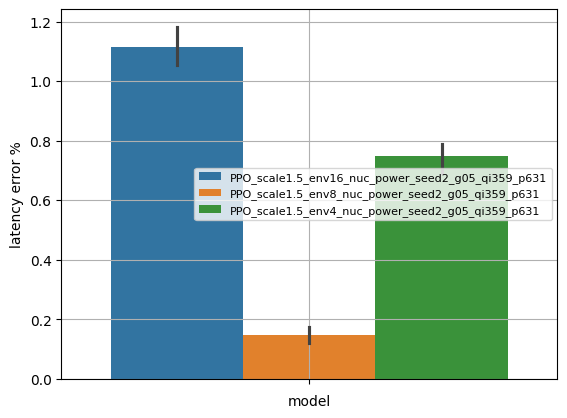

In [5]:
sns.barplot(data=run_df, y='error percent', hue='model', palette=palette)
plt.ylabel("latency error %")
plt.xlabel("model")
labs = ["scale1.5_cpu","scale1.5_power","scale1_cpu","scale1_power"]
plt.legend( loc=7, prop={'size': 8})
plt.grid()
plt.show()

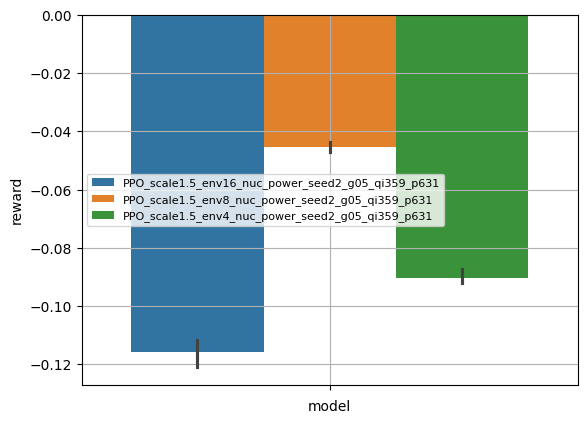

In [6]:
sns.barplot(data=run_df, y='reward', hue='model', palette=palette)
plt.ylabel("reward")
plt.xlabel("model")
labs = ["scale1.5_cpu","scale1.5_power","scale1_cpu","scale1_power"]
plt.legend( loc=6, prop={'size': 8})
plt.grid()
plt.show()

<Axes: ylabel='power'>

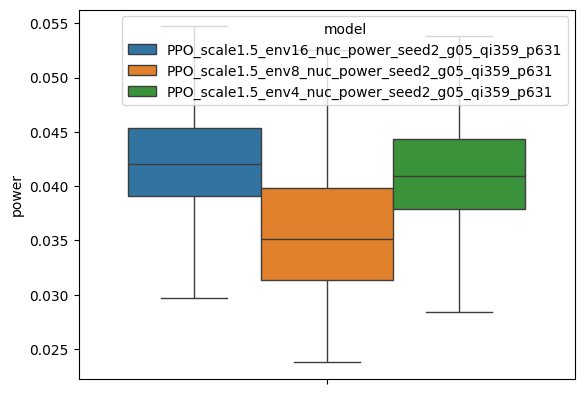

In [7]:
sns.boxplot(data=step_df, y="power", hue="model", showfliers=False, palette=palette)

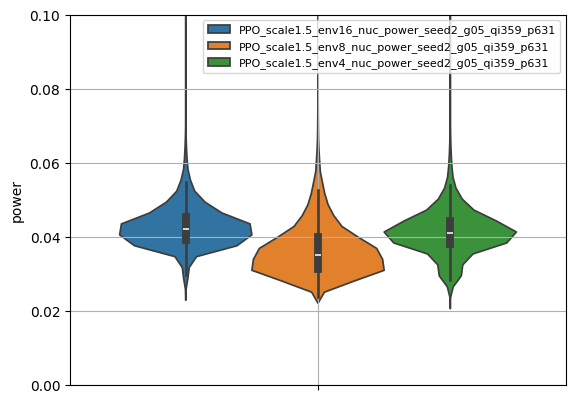

In [8]:
sns.violinplot(data=step_df, y="power", hue="model", palette=palette)
plt.ylim(0, 0.1)
plt.grid()
plt.legend(prop={'size': 8})